# Natural parameterized quantum circuit for multi-parameter sensing

"Natural parameterized quantum circuit" by T. Haug, M.S. Kim

Tghe Natural parameterized quantum circuit is a parameterized quantum circuit which has euclidean quantum geometry. That means that the quantum Fisher information metric is the identity for a particular parameter set, which we call the reference parameter. This NPQC is very useful for various applications.
- Training variational quantum algorithms
- Multi-parameter quantum sensing
- Preparation of superposition states

Here, we study multi-parameter sensing using the NPQC. The goal is determine the unknown parameters of the NPQC by measuring the quantum state. We can sense many parameters at the same time by sampling in the computational basis.

The implementation is based on qutip

@author: Tobias Haug, github txhaug
Imperial College London
Contact at tobiasxhaug@gmail.com


In [1]:
import qutip as qt

from functools import partial

import operator
from functools import reduce
import numpy as np

import scipy
import matplotlib.pyplot as plt

Set parameters for NPQC here

In [25]:

n_qubits=6 #number qubits
depth=6 #number of layers, is the number of layers of parameterized single qubit rotations

type_circuit=1##0: natural parameterized quantum circuit (NPQC), 1: natural parameterized quantum circuit with y rotations only for sensing

initial_angles=1 ##0: random angles 1: reference parameters \theta_r that has QFIM =I

distance_parameters_estimation=0.2 # norm of parameters to be estimated
    
random_seed=1#seed of random generator

n_samples=10**6 ##number of measurements for sensing



In [26]:
def prod(factors):
    return reduce(operator.mul, factors, 1)


def flatten(l):
    return [item for sublist in l for item in sublist]

#tensors operators together 
def genFockOp(op,position,size,levels=2,opdim=0):
    opList=[qt.qeye(levels) for x in range(size-opdim)]
    opList[position]=op
    return qt.tensor(opList)

#construct from parameter 1D list a 2D array with [depth,n_qubits], ignore unused rotations where paulis2d=0
def construct_2d_parameters(angles,paulis2d,extraangles=0):
    depth,n_qubits=np.shape(paulis2d)
    angles2d=np.zeros([depth,n_qubits])
    counter=0
    for i in range(depth):
        for j in range(n_qubits):
            if(paulis2d[i,j]!=0):
                angles2d[i,j]=angles[counter]
                counter+=1
    if(extraangles==0):
        return angles2d
    else:
        return angles2d,angles[counter:]

#take parameters as a 2D array with [depth,n_qubits] to do 1D list, ignore unused rotations where paulis2d=0
def construct_1d_parameters(angles2d,paulis2d):
    depth,n_qubits=np.shape(paulis2d)
    angles1d=[]
    for i in range(depth):
        for j in range(n_qubits):
            if(paulis2d[i,j]!=0):
                angles1d.append(angles2d[i,j])
    
    return np.array(angles1d)


In [27]:
if(n_qubits%2==1):
    raise NameError("Only even number of qubits allowed")


#random generator used
rng = np.random.default_rng(random_seed)

#define angles for circuit
ini_angles=np.zeros([depth,n_qubits])
if(initial_angles==0):
    ini_angles=rng.random([depth,n_qubits])*2*np.pi
elif(initial_angles==1): #choose angles as \theta_r as defined in paper
    ini_angles[1:depth:2,:]=0
    ini_angles[0:depth:2,:]=np.pi/2
    #note that not all angles are actually used, the ones where ini_pauli=0 are ignored


#define rotations for circuit in each layer, 0: identity, 1: X, 2:Y 3:Z
ini_pauli=np.zeros([depth,n_qubits],dtype=int)

##set initial layer of pauli rotations
if(type_circuit==0):#NPQC
    #set first and second layer, rest comes later
    ini_pauli[0,:]=2 #y rotation
    if(depth>1):
        ini_pauli[1,:]=3 #z rotation
        
elif(type_circuit==1): #NPQC with y rotations only for sensing
    #set first and second layer, rest comes later
    ini_pauli[0,:]=2 #y rotation      

        
##define entangling layers and add more pauli rotations
if(type_circuit==0 or type_circuit==1):   
    #construct natural parameterized circuit
    entangling_gate_index_list=[[] for i in range(depth)] ##stores where entangling gates are placed
    orderList=[]
    for i in range(n_qubits//2):
        if(i%2==0):
            orderList.append(i//2)
        else:
            orderList.append((n_qubits-i)//2)

    if(n_qubits>1):
        shiftList=[orderList[0]]
    else:
        shiftList=[]
    for i in range(1,n_qubits//2):
        shiftList.append(orderList[i])
        shiftList+=shiftList[:-1]

    #this list gives which entangling gates are applied in which layer
    for j in range(min(len(shiftList),int(np.ceil(depth/2))-1)):
        entangling_gate_index_list[1+2*j]=[[2*i,(2*i+1+2*shiftList[j])%n_qubits,3] for i in range(n_qubits//2)]

    #this is the 2 qubit entangling operation, it is a pi/2 y rotation on first qubit with CPHASE gate
    U_entangling=qt.qip.operations.csign(2,0,1)*qt.tensor(qt.qip.operations.ry(np.pi/2),qt.qeye(2))
    for i in range(len(entangling_gate_index_list)-1):
        if(len(entangling_gate_index_list[i])>0):
            for j in range(len(entangling_gate_index_list[i])):
                ini_pauli[i+1,entangling_gate_index_list[i][j][0]]=2
                if(i+2<depth and type_circuit==0):##add z rotations, but not for sensing NPQC
                    ini_pauli[i+2,entangling_gate_index_list[i][j][0]]=3




#operators for circuit
levels=2#
opZ=[genFockOp(qt.sigmaz(),i,n_qubits,levels) for i in range(n_qubits)]
opX=[genFockOp(qt.sigmax(),i,n_qubits,levels) for i in range(n_qubits)]
opY=[genFockOp(qt.sigmay(),i,n_qubits,levels) for i in range(n_qubits)]
opId=genFockOp(qt.qeye(levels),0,n_qubits)
opZero=opId*0
zero_state=qt.tensor([qt.basis(levels,0) for i in range(n_qubits)])
      
#construct unitaries for entangling layer
all_entangling_layers=[]         
for ind in range(len(entangling_gate_index_list)):
    if(type_circuit==0 or type_circuit==1):  
        entangling_gate_index=entangling_gate_index_list[ind]
        if(len(entangling_gate_index)==0):
            entangling_layer=opId
        else:
            entangling_layer=prod([qt.qip.operations.gate_expand_2toN(U_entangling,n_qubits,j,k) for j,k,n in entangling_gate_index[::-1]])
    
    all_entangling_layers.append(entangling_layer)

#calculate number of parameters
n_parameters=len(construct_1d_parameters(ini_angles,ini_pauli))



##check which paulis at what depth and qubit is identitity or not
parameter_where=np.zeros([n_parameters,2],dtype=int)
counter=0
for i in range(depth):
    for j in range(n_qubits):
        if(ini_pauli[i,j]!=0):
            parameter_where[counter]=[i,j]
            counter+=1
       

#save single qubit rotations unitary with fixed ini_angles. Use them later for the adjoint circuit needed for sensing
save_initial_rot_op=[]
for j in range(depth):
    rot_op=[]
    for k in range(n_qubits):
        angle=ini_angles[j][k]
        type_pauli=ini_pauli[j][k]
        if(type_pauli==1):
            rot_op.append(qt.qip.operations.rx(angle))
        elif(type_pauli==2):
            rot_op.append(qt.qip.operations.ry(angle))
        elif(type_pauli==3):
            rot_op.append(qt.qip.operations.rz(angle))
        elif(type_pauli==0):
            rot_op.append(qt.qeye(2))

    save_initial_rot_op.append(qt.tensor(rot_op))


##H=opZ[0]*opZ[1] #local Hamiltonian to calculate energy and gradient from

print("Number of parameters of PQC",n_parameters)

Number of parameters of PQC 12


In [28]:
##calc_mode #0: calc all gradients 1: calc frame potential only 2: calc both, 3: only get gradient
##can apply adjoint unitary with fixed angles  "add_adjoint_unitary" for sensing
def do_calc(input_angles,input_paulis,get_gradients=True,add_adjoint_unitary=False):
    
    initial_state_save=qt.tensor([qt.basis(levels,0) for i in range(n_qubits)])

    #save here quantum state of gradient for qfi
    grad_state_list=[]
    #list of values of gradient
    gradient_list=np.zeros(n_parameters)
    
    save_rot_op=[]
    #save single-qubit rotations here so we can reuse them
    for j in range(depth):
        rot_op=[]
        for k in range(n_qubits):
            angle=input_angles[j][k]
            type_pauli=input_paulis[j][k]
            if(type_pauli==1):
                rot_op.append(qt.qip.operations.rx(angle))
            elif(type_pauli==2):
                rot_op.append(qt.qip.operations.ry(angle))
            elif(type_pauli==3):
                rot_op.append(qt.qip.operations.rz(angle))
            elif(type_pauli==0):
                rot_op.append(qt.qeye(2))
                
        save_rot_op.append(qt.tensor(rot_op))
        

    #p goes from -1 to n_parameters-1. -1 is to calculate quantum state, rest for gradient
    if(get_gradients==True):
        #calculate gradients by doing n_parameters+1 calcuations
        n_p=n_parameters
    else:
        #without gradient, need only one calculation
        n_p=0
        
    for p in range(-1,n_p):
        initial_state=qt.Qobj(initial_state_save)

        for j in range(depth):
            apply_rot_op=save_rot_op[j]
            
            #for p>=0, we are calculating gradients. Here, we need to add derivative of repsective parameter
            if(p!=-1 and j==parameter_where[p][0]):
                which_qubit=parameter_where[p][1]
                type_pauli=input_paulis[j][which_qubit]
                if(type_pauli==1):
                    apply_rot_op=apply_rot_op*(-1j*opX[which_qubit]/2)
                elif(type_pauli==2):
                    apply_rot_op=apply_rot_op*(-1j*opY[which_qubit]/2)
                elif(type_pauli==3):
                    apply_rot_op=apply_rot_op*(-1j*opZ[which_qubit]/2)

            #apply single qubit rotations
            initial_state=apply_rot_op*initial_state


            #apply entangling layer
            initial_state=all_entangling_layers[j]*initial_state


        #after constructing the circuit, apply inverse with parameters fixed to ini_angles  
        if(add_adjoint_unitary==True):#apply inverse of circuit for sensing
            for j in np.arange(depth)[::-1]:
                initial_state=all_entangling_layers[j].dag()*initial_state
                initial_state=save_initial_rot_op[j].dag()*initial_state



         
        if(p==-1):
            #calculate loss
            circuit_state=qt.Qobj(initial_state)#state generated by circuit
            if(loss_hamiltonian==True):
                #loss is hamiltonian
                loss=qt.expect(H,circuit_state)
            else:
                #loss is infidelity with target state H_state
                loss=1-np.abs(circuit_state.overlap(H_state))**2

    
        else:
            #calculate gradient
            grad_state_list.append(qt.Qobj(initial_state))#state with gradient applied for p-th parameter

            if(loss_hamiltonian==True):
                gradient_list[p]=2*np.real(circuit_state.overlap(H*initial_state))
            else:
                gradient_list[p]=2*np.real(circuit_state.overlap(initial_state)-circuit_state.overlap(H_state)*H_state.overlap(initial_state))


    return circuit_state,grad_state_list,loss,gradient_list

In [29]:
#construct parameters of state to be estimated
loss_hamiltonian=False #loss is inifidelity 1-F

#we shift parameterized quantum circuit from initial parameters by a fixed distance.
#we know approximatly what distance corresponds to what fidelity

#get random normalized parameter vector
random_vector_opt_normed=(2*rng.random(np.shape(ini_pauli))-1)*(ini_pauli!=0)
random_vector_opt_normed=random_vector_opt_normed/np.sqrt(np.sum(np.abs(random_vector_opt_normed)**2))

#shift parameters by the following distance,. We use resulting state for estimation
factor_rand_vector=distance_parameters_estimation

    
#construct parameter of state to be learned
target_angles=ini_angles+random_vector_opt_normed*factor_rand_vector

H_state=zero_state #set so do_calc runs properly

In [30]:
#quantum fisher information metric
#calculated as \text{Re}(\braket{\partial_i \psi}{\partial_j \psi}-\braket{\partial_i \psi}{\psi}\braket{\psi}{\partial_j \psi})

##get gradients for quantum state
circuit_state,grad_state_list,energy,gradient_list=do_calc(ini_angles,ini_pauli,get_gradients=True)


#first, calculate elements \braket{\psi}{\partial_j \psi})
single_qfi_elements=np.zeros(n_parameters,dtype=np.complex128)
for p in range(n_parameters):
    #print(circuit_state.overlap(grad_state_list[p]))
    single_qfi_elements[p]=circuit_state.overlap(grad_state_list[p])
            

#calculcate the qfi matrix
qfi_matrix=np.zeros([n_parameters,n_parameters])
for p in range(n_parameters):
    for q in range(p,n_parameters):
        qfi_matrix[p,q]=np.real(grad_state_list[p].overlap(grad_state_list[q])-np.conjugate(single_qfi_elements[p])*single_qfi_elements[q])
    
    
#use fact that qfi matrix is real and hermitian
for p in range(n_parameters):
    for q in range(p+1,n_parameters):  
        qfi_matrix[q,p]=qfi_matrix[p,q]
        
        


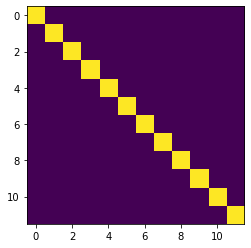

In [31]:
##plot the quantum Fisher information metric (QFIM)
#should be a diagonal with zero off-diagonal entries for initial_angles=1
plt.imshow(qfi_matrix)

In [32]:



if(type_circuit==1): #NPQC with y rotations only for sensing
    hilbertspace=2**n_qubits
    
    ##get reference state and gradients to determine which parameter belongs to which computational state
    circuit_state_reuse,grad_state_list_reuse,_,gradient_list=do_calc(ini_angles,ini_pauli,get_gradients=True,add_adjoint_unitary=True)
    
    ##first, figure out which parameter changes which computational basis state
    parameter_which_state=np.zeros(n_parameters,dtype=int) #tells us which state belongs to which parameter
    
    state_which_parameter=np.ones(hilbertspace,dtype=int)*-1
    for i in range(n_parameters):
        grad_abs=np.abs(grad_state_list_reuse[i].data.toarray()[:,0])**2

        index=(np.arange(hilbertspace)[grad_abs>10**-14])
        if(len(index)!=1):
            raise NameError("More than one direction!")
        else:
            parameter_which_state[i]=index[0]
            state_which_parameter[index[0]]=i

    #check if a computational basis states belongs to more than one parameter
    if(len(np.unique(parameter_which_state))!=len(parameter_which_state)):
    
        raise NameError("Double occupations of computational states for sensing!")

    #get difference between target angles and reference angles. We now want to estimate this from measurements!
    exact_sensing_parameters=construct_1d_parameters(target_angles-ini_angles,ini_pauli)

    norm_sensing_parameters=np.sqrt(np.sum(np.abs(exact_sensing_parameters)**2))
    
    print("Norm of parameters to be sensed",norm_sensing_parameters)
    ##get state that we use for sensing and want to know its parameters
    target_state,_,energy,_=do_calc(target_angles,ini_pauli,get_gradients=False,add_adjoint_unitary=True)
    
    #sample from target state, then identify parameters
    probs=np.abs(target_state.data.toarray()[:,0])**2


    print("Probability zero state",probs[0])

    #get exact probability term assoicate with each parameter
    prob_parameters=np.zeros(n_parameters)
    for i in range(n_parameters):
        prob_parameters[i]=probs[parameter_which_state[i]]


    #now sample probabilities to simulate measurements with finite number of measurements
    ##get sampled probabilities for each sensing parameter
    sampled_probs=np.zeros(n_parameters)
    sample_index = np.random.choice(hilbertspace,n_samples,p=probs)
    for k in range(n_samples):
        index_parameter=state_which_parameter[sample_index[k]]
        if(index_parameter>=0):
            sampled_probs[index_parameter]+=1

    sampled_probs/=n_samples

    ##parameters we estimated by sampling state
    sampled_estimation_parameters=2*np.sqrt(sampled_probs)


    MSE_bound=n_parameters/n_samples

    ##parameters as estimated by our protocol for infinite number of shots
    infinite_shots_estimation_parameters=2*np.sqrt(prob_parameters)

    ##error for infinite sampling
    MSE_infinite=np.mean(np.abs(infinite_shots_estimation_parameters-np.abs(exact_sensing_parameters))**2)

    rel_RMSE_error_infinite=np.sqrt(MSE_infinite)/np.mean(np.abs(exact_sensing_parameters))


    MSE_sampled=np.mean(np.abs(sampled_estimation_parameters-np.abs(exact_sensing_parameters))**2)

    rel_RMSE_error_sampled=np.sqrt(MSE_sampled)/np.mean(np.abs(exact_sensing_parameters))
    #MSE_sampled=np.mean(np.abs(sampled_estimation_parameters-np.abs(infinite_shots_estimation_parameters))**2)



    print("Sensing",n_parameters,"parameters with",n_samples)

    print("Mean-square error of infinite samples",MSE_infinite)

    print("MSE of infinite samples relative to exact norm of exact parameters",rel_RMSE_error_infinite)

    print("Mean-square error of finite samples",MSE_sampled)
    print("MSE sampled with finite shots relative to norm of exact parameters",rel_RMSE_error_sampled)




Norm of parameters to be sensed 0.20000000000000007
Probability zero state 0.9901913239361995
Sensing 12 parameters with 1000000
Mean-square error of infinite samples 3.804870428072372e-06
MSE of infinite samples relative to exact norm of exact parameters 0.0395784284812979
Mean-square error of finite samples 4.020576027847638e-06
MSE sampled with finite shots relative to norm of exact parameters 0.040684852841565616
